## Amazon Bedrock Text-to-SQL Evaluation

### Intro and Goal
This Jupyter Notebook is designed to illustrate Text-to-SQL evaluation.

The goal is to take highlight programmatic evaluation metrics as well as LLM as a Judge.

The notebook is structured as follows:
1. Download ground truth dataset comprised of questions and SQL queries for a given database (e.g. Northwind)
2. Evaluate accuracy, cost, and latency of different Text-to-SQL approaches compared to the baseline (zero-shot prompting) for all queries.

In [1]:
# 1. Import necessary libraries and load environment variables
from dotenv import load_dotenv, find_dotenv
import os
import pandas as pd

# loading environment variables that are stored in local file
local_env_filename = 'dev.env'
load_dotenv(find_dotenv(local_env_filename),override=True)

os.environ['REGION'] = os.getenv('REGION')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')
os.environ['SQL_DATABASE'] = os.getenv('SQL_DATABASE') # LOCAL, SQLALCHEMY, REDSHIFT
os.environ['SQL_DIALECT'] = os.getenv('SQL_DIALECT') # SQlite, PostgreSQL
os.environ['ENDPOINT_NAME'] = os.getenv('ENDPOINT_NAME')


REGION = os.environ['REGION']
HF_TOKEN = os.environ['HF_TOKEN']
SQL_DATABASE = os.environ['SQL_DATABASE']
SQL_DIALECT = os.environ['SQL_DIALECT']
ENDPOINT_NAME = os.environ['ENDPOINT_NAME']

MODEL_ID = "anthropic.claude-3-haiku-20240307-v1:0" #anthropic.claude-3-sonnet-20240229-v1:0" # anthropic.claude-3-haiku-20240307-v1:0 "anthropic.claude-3-5-sonnet-20240620-v1:0" "meta.llama3-1-70b-instruct-v1:0"
EVAL_MODEL_ID = "anthropic.claude-3-sonnet-20240229-v1:0"

# get ground truth data
file_path = './data/ground_truth.jsonl'
groundtruth_df = pd.read_json(file_path, lines=True)

print(f"Using database: {SQL_DATABASE} with sql dialect: {SQL_DIALECT}")

Using database: SQLALCHEMY with sql dialect: PostgreSQL


### Evaluation

In [2]:
#2. Grading prompt

evaluation_template = """You are a SQL expert. 
                Your task is to evaluate a given SQL query based on a provided SQL schema and question using the criteria provided below.
 
                Evaluation Criteria (Additive Score, 0-5):
                1. Context: Award 1 point if the generated SQL query uses only information provided in the SQL schema, without introducing external or fabricated details.
                2. Completeness: Add 1 point if the generated SQL query addresses all key elements of the question based on the available SQL schema and Exact Set Match Accuracy (EM) score.
                3. ExecutionAccuracy: Add 1 point if the generated SQL query is very close to the groundtruth answer based on Execution Accuracy score.
                4. Faultless: Add 1 point if the generated SQL query ran without any errors.
                5. ValidEfficiencyScore:  Add 1 point if the runtime of the generated SQL query is similar or better than the the groundtruth qery as measured by the Valid Efficiency Score (VES).
                
                Evaluation Steps:
                1. Read provided context, question and answer carefully.
                2. Go through each evaluation criterion one by one and assess whether the answer meets the criteria.
                3. Compose your reasoning for each critera, explaining why you did or did not award a point. You can only award full points. 
                4. Calculate the total score by summing the points awarded.
                5. Think through the evaluation criteria inside <thinking></thinking> tags. 
                Then, output the total score inside <score></score> tags.
                Review your formatted response. It needs to be valid XML.
    
                Original question:
                <question>
                {question}
                </question>

                SQL schema:
                <sql_schema>
                {sql_schema}
                </sql_schema>

                Generated SQL query based on these instructions:
                <sql_query>
                {sql_query}
                </sql_query>

                SQL result based on the generated SQL query:
                <sql_query_run_result>
                {sql_query_run_result}
                </sql_query_run_result>

                Any SQL errors that might have occured based on the generated SQL query:
                <sql_query_run_error>
                {sql_query_run_error}
                </sql_query_run_error>

                Groundtruth SQL query for comparison with the generated SQL query:
                <groundtruth_sql_query>
                {groundtruth_sql_query}
                </groundtruth_sql_query>
                
                Execution Accuracy, which compares the generated SQL query to the labeled SQL query to determine if its a match or not: 
                <ex_score>
                {ex_score}
                </ex_score>
                
                Exact Set Match Accuracy (EM), which evaluates if the returned result set actually answers the question, regardless of how the query was written: 
                <em_score>
                {em_score}
                </em_score>

                Valid Efficiency Score (VES), which compares the runtime of the SQL provided as groundtruth to the generated SQL query:
                <ves_score>
                {ves_score}
                </ves_score>                
                """

In [3]:
# 3. Run eval with zero-shot template 
# Zero-shot SQL prompt template to establish baseline
from utils.eval import AnswerTaskRunner

## added "Always prefix table names with the "public." prefix." to support running queries via sqlalchemy 
zero_shot_sql_template = """You are a SQL expert. You will be provided with the original user question and a SQL database schema. 
                Only return the SQL query and nothing else.
                
                User question:
                <user_question>
                {user_question}
                </user_question>

                SQL database schema:
                <sql_database_schema>
                {sql_database_schema}
                </sql_database_schema>
                
                SQL dialect:
                <sql_dialect>
                {sql_dialect}
                </sql_dialect>

                Instructions:
                Generate a SQL query that answers the original user question.
                Use the schema, first create a syntactically correct {sql_dialect} query to answer the question. 
                Never query for all the columns from a specific table, only ask for a few relevant columns given the question.
                Always prefix table names with the "public." prefix.
                Pay attention to use only the column names that you can see in the schema description. 
                Be careful to not query for columns that do not exist. 
                Pay attention to which column is in which table. 
                Also, qualify column names with the table name when needed.
                If you cannot answer the user question with the help of the provided SQL database schema, 
                then output that this question question cannot be answered based of the information stored in the database.
                You are required to use the following format, each taking one line:
                Return the sql query inside the <sql></sql> tab.
                """



answer_results1: pd.DataFrame = AnswerTaskRunner(groundtruth_df[:10],
                 model_id=MODEL_ID,
                 eval_model_id=EVAL_MODEL_ID,
                 sql_database=SQL_DATABASE,
                 sql_dialect=SQL_DIALECT,
                 prompt_template=zero_shot_sql_template,
                 prompt_eval_template=evaluation_template).run()

answer_results1.to_json('./data/zero-shot-graded.jsonl', orient='records', lines=True, force_ascii=False, date_format='iso', default_handler=str)

In [4]:
answer_results1.head(5)

,user_question,groundtruth_query,generated_sql_query,score,reasoning,usage,latency,cost,ex_score,em_score,ves_score,sql_query_run_error,sql_query_run_result,context
0,What is the total number of customers?,SELECT COUNT(*) FROM customers;,SELECT COUNT(public.customers.customer_id) AS ...,5,Context: The generated SQL query uses only the...,"{""inputTokens"": 1545, ""outputTokens"": 32, ""tot...",877,0.000426,0.0,1.0,1.000000,None,[(91)],CREATE TABLE categories (\n category_id sma...
1,List all product names and their unit prices.,"SELECT product_name, unit_price FROM products;","SELECT public.products.product_name, public.pr...",4,1. Context: The generated SQL query uses only ...,"{""inputTokens"": 1546, ""outputTokens"": 33, ""tot...",491,0.000428,0.0,1.0,0.932268,None,"[(Chai, 18.0), (Chang, 19.0), (Aniseed Syrup, ...",CREATE TABLE categories (\n category_id sma...
2,Who are the top 5 customers by order count?,"SELECT c.company_name, COUNT(o.order_id) as or...","SELECT public.customers.company_name, COUNT(pu...",4,Context (1 point):\nThe generated SQL query us...,"{""inputTokens"": 1549, ""outputTokens"": 83, ""tot...",897,0.000491,0.0,1.0,1.000000,None,"[(Save-a-lot Markets, 31), (Ernst Handel, 30),...",CREATE TABLE categories (\n category_id sma...
3,What is the average freight cost for orders?,SELECT AVG(freight) FROM orders;,SELECT AVG(public.orders.freight) AS average_f...,5,Context: The generated SQL query uses only the...,"{""inputTokens"": 1546, ""outputTokens"": 33, ""tot...",621,0.000428,0.0,1.0,0.958897,None,[(78.244204877492)],CREATE TABLE categories (\n category_id sma...
4,List all employees with their full names and t...,"SELECT employee_id, first_name || ' ' || last_...","SELECT public.employees.first_name, public.emp...",2,Context:\nThe generated SQL query uses only th...,"{""inputTokens"": 1547, ""outputTokens"": 39, ""tot...",618,0.000436,0.0,0.0,0.000000,None,"[(Andrew, Fuller, Vice President, Sales), (Jan...",CREATE TABLE categories (\n category_id sma...


In [ ]:
# # 4. Run eval with few-shot template  ( TO DO )
# # Few-shot SQL prompt template to establish baseline
# few_shot_sql_template = """You are a SQL expert. You will be provided with the original user question and a SQL database schema. 
#                 Only return the SQL query and nothing else.
                
#                 User question:
#                 <user_question>
#                 {user_question}
#                 </user_question>

#                 SQL database schema:
#                 <sql_database_schema>
#                 {sql_database_schema}
#                 </sql_database_schema>
                
#                 SQL dialect:
#                 <sql_dialect>
#                 {sql_dialect}
#                 </sql_dialect>

#                 Instructions:
#                 Generate a SQL query that answers the original user question.
#                 Use the schema, first create a syntactically correct {sql_dialect} query to answer the question. 
#                 Never query for all the columns from a specific table, only ask for a few relevant columns given the question.
#                 Pay attention to use only the column names that you can see in the schema description. 
#                 Be careful to not query for columns that do not exist. 
#                 Pay attention to which column is in which table. 
#                 Also, qualify column names with the table name when needed.
#                 If you cannot answer the user question with the help of the provided SQL database schema, 
#                 then output that this question question cannot be answered based of the information stored in the database.
#                 You are required to use the following format, each taking one line:
#                 Return the sql query inside the <sql></sql> tab. Similar to the examples provided below.

#                 <examples>
                    
#                 </examples>
#                 """

# answer_results2: pd.DataFrame = AnswerTaskRunner(groundtruth_df,
#                  model_id=MODEL_ID,
#                  eval_model_id=EVAL_MODEL_ID,
#                  sql_database=SQL_DATABASE,
#                  sql_dialect=SQL_DIALECT,
#                  prompt_template=few_shot_sql_template,
#                  prompt_eval_template=evaluation_template).run()

# answer_results2.to_json('./data/few-shot-graded.jsonl', orient='records', lines=True, force_ascii=False, date_format='iso', default_handler=str)

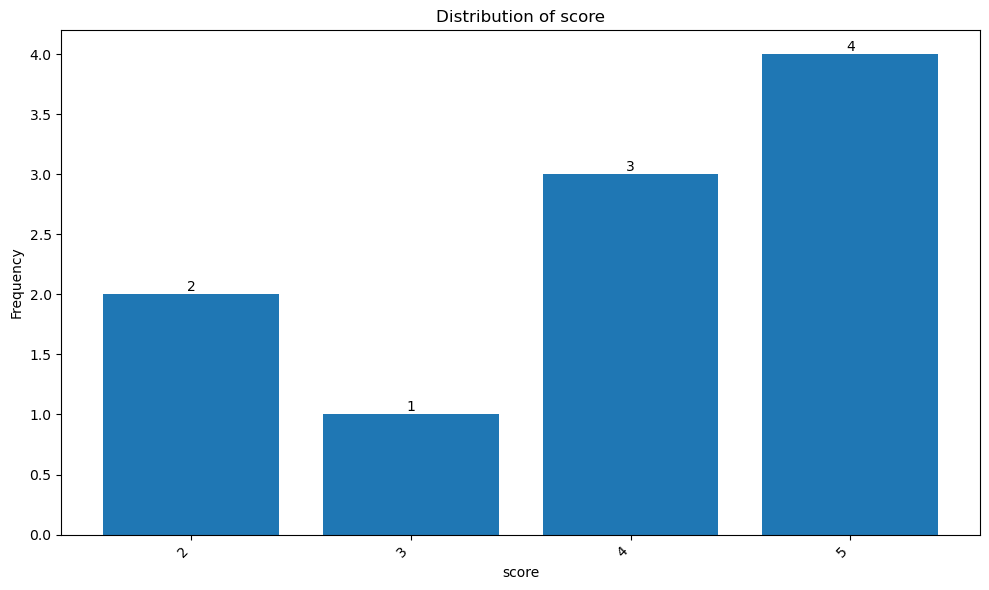

In [8]:
# 5. Compare results
from utils.util import Util
util = Util()
# util.compare_results(answer_results2, answer_results1)
util.visualize_distribution(answer_results1, key='score')
# util.visualize_distribution(answer_results2,key='score')

In [9]:
# 6. Review results
print(f'sum of zero_shot_cost: {answer_results1["cost"].sum()}')
# print(f'sum of few_shot_cost: {answer_results2["cost"].sum()}')

print(f'avg of zero_shot_query_time: {answer_results1["latency"].mean()}')
# print(f'avg of few_shot_query_time: {answer_results2["latency"].mean()}')

# Execution Accuracy, which compares the generated SQL query to the ground truth SQL query to determine if its a match
print(f'avg of ex_score of zero_shot: {answer_results1["ex_score"].mean()}')
# print(f'avg of ex_score of few_shot: {answer_results2["ex_score"].mean()}')
# Exact Set Match Accuracy (EM), which evaluates if the generated SQL query resultset matches the ground truth resultset
print(f'avg of em_score of zero_shot: {answer_results1["em_score"].mean()}')
# print(f'avg of em_score of few_shot: {answer_results2["em_score"].mean()}')
# Valid Efficiency Score (VES), which compares the  generated router SQL query runtime provided to the ground truth SQL query runtime
print(f'avg of ves_score of zero_shot: {answer_results1["ves_score"].mean()}')
# print(f'avg of ves_score of few_shot: {answer_results2["ves_score"].mean()}')

sum of zero_shot_cost: 0.004511499999999999
avg of zero_shot_query_time: 734.0
avg of ex_score of zero_shot: 0.0
avg of em_score of zero_shot: 0.7
avg of ves_score of zero_shot: 0.6850539019374426


In [10]:
# 7. Run eval with finetuned LLM and zero-shot template
from utils.eval import AnswerTaskRunner
zero_shot_sql_template = """{user_question} \n\n### Context {sql_database_schema}"""
answer_results3: pd.DataFrame = AnswerTaskRunner(groundtruth_df[:10],
                 model_id="",
                 endpoint_name=ENDPOINT_NAME,
                 max_token_count=512,
                 eval_model_id=EVAL_MODEL_ID,
                 sql_database=SQL_DATABASE,
                 sql_dialect=SQL_DIALECT,
                 prompt_template=zero_shot_sql_template,
                 prompt_eval_template=evaluation_template,
                 region=REGION).run()

answer_results3.to_json('./data/zero-shot-finetuned-graded.jsonl', orient='records', lines=True, force_ascii=False, date_format='iso', default_handler=str)

Error executing SQL: (psycopg2.errors.GroupingError) column "t1.customer_id" must appear in the GROUP BY clause or be used in an aggregate function
LINE 1: SELECT T1.customer_id FROM customers AS T1 JOIN customer_cus...
               ^

[SQL: SELECT T1.customer_id FROM customers AS T1 JOIN customer_customer_demo AS T2 ON T1.customer_id = T2.customer_id JOIN customer_demographics AS T3 ON T2.customer_type_id = T3.customer_type_id ORDER BY COUNT(*) DESC LIMIT 5]
(Background on this error at: https://sqlalche.me/e/20/f405)
Error executing SQL: (psycopg2.errors.UndefinedColumn) column "freight_cost" does not exist
LINE 1: SELECT AVG(freight_cost) FROM products
                   ^

[SQL: SELECT AVG(freight_cost) FROM products]
(Background on this error at: https://sqlalche.me/e/20/f405)
Error executing SQL: (psycopg2.errors.UndefinedColumn) column "current_on_hand" does not exist
LINE 1: SELECT SUM(current_on_hand) FROM products
                   ^

[SQL: SELECT SUM(current_on_hand) FROM

In [11]:
answer_results3.head(5)

,user_question,groundtruth_query,generated_sql_query,score,reasoning,usage,latency,cost,ex_score,em_score,ves_score,sql_query_run_error,sql_query_run_result,context
0,What is the total number of customers?,SELECT COUNT(*) FROM customers;,SELECT COUNT(*) FROM customers,5,Context: The generated SQL query uses only the...,0,1.157753,0,0.0,1.0,1.000000,None,[(91)],CREATE TABLE categories (\n category_id sma...
1,List all product names and their unit prices.,"SELECT product_name, unit_price FROM products;","SELECT product_name, unit_price FROM products",5,Context: The generated SQL query uses only the...,0,1.269974,0,0.0,1.0,0.615082,None,"[(Chai, 18.0), (Chang, 19.0), (Aniseed Syrup, ...",CREATE TABLE categories (\n category_id sma...
2,Who are the top 5 customers by order count?,"SELECT c.company_name, COUNT(o.order_id) as or...",SELECT T1.customer_id FROM customers AS T1 JOI...,1,Context (1 point):\nThe generated SQL query us...,0,4.354324,0,0.0,0.0,0.000000,"(psycopg2.errors.GroupingError) column ""t1.cus...",None,CREATE TABLE categories (\n category_id sma...
3,What is the average freight cost for orders?,SELECT AVG(freight) FROM orders;,SELECT AVG(freight_cost) FROM products,1,Context (1 point):\nThe generated SQL query do...,0,1.301083,0,0.0,0.0,0.000000,"(psycopg2.errors.UndefinedColumn) column ""frei...",None,CREATE TABLE categories (\n category_id sma...
4,List all employees with their full names and t...,"SELECT employee_id, first_name || ' ' || last_...","SELECT first_name, last_name, title FROM emplo...",3,Context (1 point):\nThe generated SQL query us...,0,1.630194,0,0.0,0.0,0.000000,None,"[(Andrew, Fuller, Vice President, Sales), (Jan...",CREATE TABLE categories (\n category_id sma...


In [12]:
# 11. Compare fine-tuned model results with zero-shot prompting

print(f'avg of zero-shot_query_time: {answer_results1["latency"].mean()}')
print(f'avg of finetuned_query_time: {answer_results3["latency"].mean()}')

# Execution Accuracy, which compares the generated SQL query to the ground truth SQL query to determine if its a match
print(f'avg of ex_score of zero_shot: {answer_results1["ex_score"].mean()}')
print(f'avg of ex_score of finetuned: {answer_results3["ex_score"].mean()}')
# Exact Set Match Accuracy (EM), which evaluates if the generated SQL query resultset matches the ground truth resultset
print(f'avg of em_score of zero_shot: {answer_results1["em_score"].mean()}')
print(f'avg of em_score of finetuned: {answer_results3["em_score"].mean()}')
# Valid Efficiency Score (VES), which compares the  generated router SQL query runtime provided to the ground truth SQL query runtime
print(f'avg of ves_score of zero_shot: {answer_results1["ves_score"].mean()}')
print(f'avg of ves_score of finetuned: {answer_results3["ves_score"].mean()}')

avg of zero-shot_query_time: 734.0
avg of finetuned_query_time: 1.849220371246338
avg of ex_score of zero_shot: 0.0
avg of ex_score of finetuned: 0.0
avg of em_score of zero_shot: 0.7
avg of em_score of finetuned: 0.2
avg of ves_score of zero_shot: 0.6850539019374426
avg of ves_score of finetuned: 0.1615081503319045


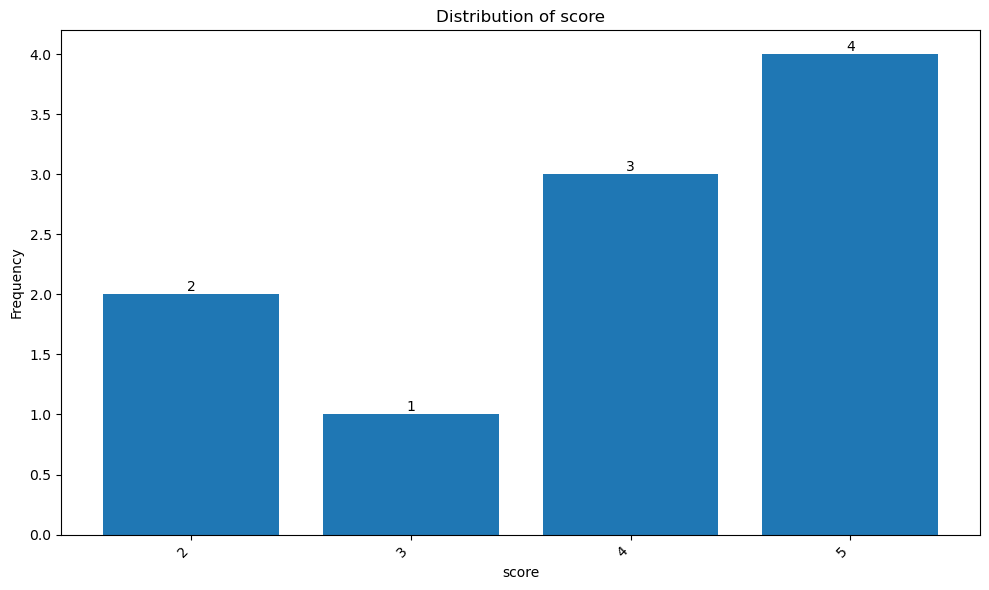

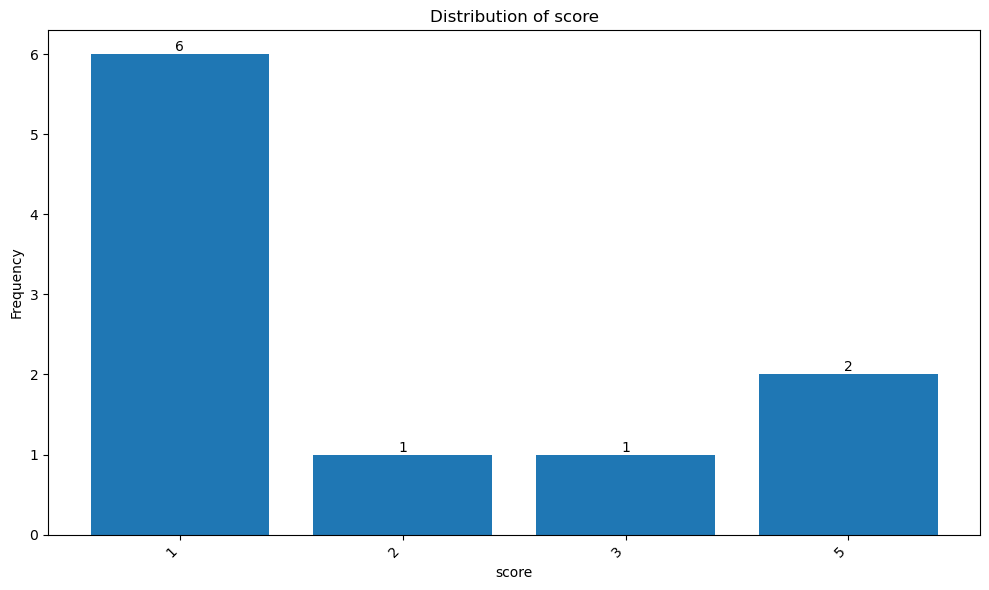

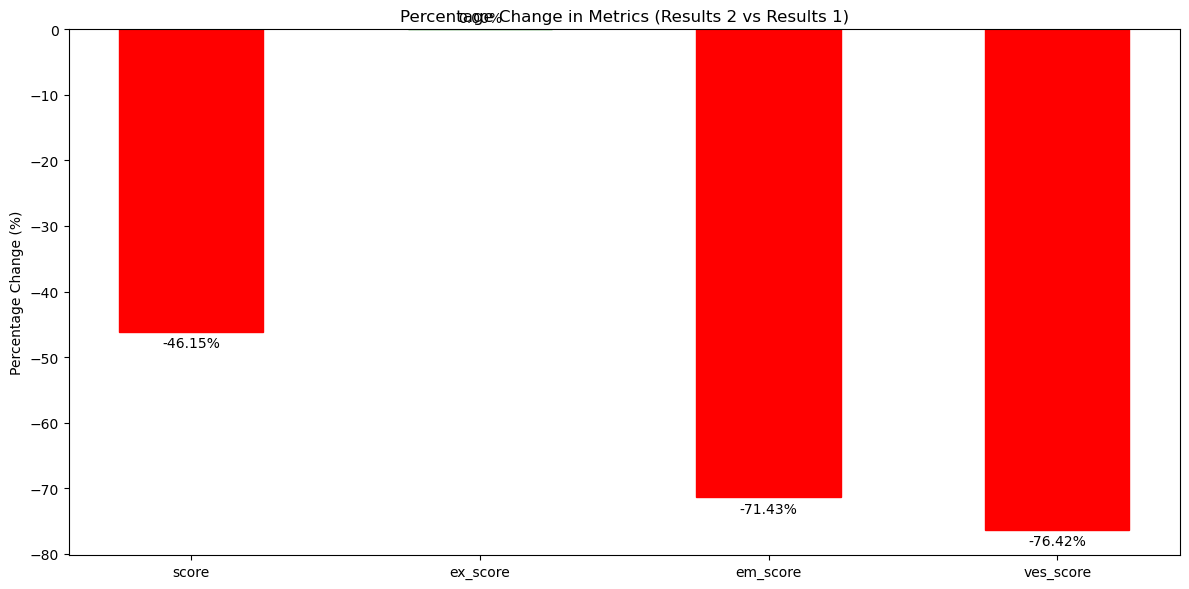

In [13]:
util = Util()
metrics = ['score', 'ex_score', 'em_score', 'ves_score'] # 'latency' ,'cost'
util.visualize_distribution(answer_results1, key='score')
util.visualize_distribution(answer_results3, key='score')
util.compare_results(answer_results1, answer_results3, metrics)

### Conclusion
XXX